<h1>생성 모델</h1>

In [ ]:
# 라이브러리
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# MNIST 데이터, 1D 데이터로 Flatten하여 사용
mnist = tf.keras.datasets.mnist
(xtrain,ytrain), (xtest,ytest) = mnist.load_data()
xtrain, xtest = xtrain/255.0, xtest/255.0
xtrain = xtrain.reshape( (len(xtrain), 28*28) )
xtest = xtest.reshape( (len(xtest), 28*28) )
print( xtrain.shape, xtest.shape )

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 784) (10000, 784)


# VAE

In [ ]:
# 네트워크 파라메터
input_size = 784
n_hidden = 256
latent_size = 2

Encoder

In [ ]:
# 샘플링 함수: N(m,v)에서 난수를 추출
def sampling(args):
    m, v = args  # v는 log(var)
    epsilon = tf.random.normal( shape=tf.shape(m) )
    return m + tf.math.exp(0.5 * v) * epsilon   # N(0,1) -> N(m,v)

In [ ]:
input = tf.keras.Input(shape=(input_size,), name='input')
hidden = tf.keras.layers.Dense(
    n_hidden, activation='relu', name='hidden')(input)
z_mean = tf.keras.layers.Dense(latent_size, name='z_mean')(hidden)
z_var = tf.keras.layers.Dense(latent_size, name='z_var')(hidden)
z = tf.keras.layers.Lambda(sampling, name='z_sampling')([z_mean, z_var])
encoder = tf.keras.Model( input, [z_mean, z_var, z] )

In [ ]:
encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 784)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden (Dense)      │ (None, 256)       │    200,960 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        514 │ hidden[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_var (Dense)       │ (None, 2)         │        514 │ hidden[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_sampling (Lambda) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_var[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 201,988 (789.02 KB)

 Trainable params: 201,988 (789.02 KB)

 Non-trainable params: 0 (0.00 B)

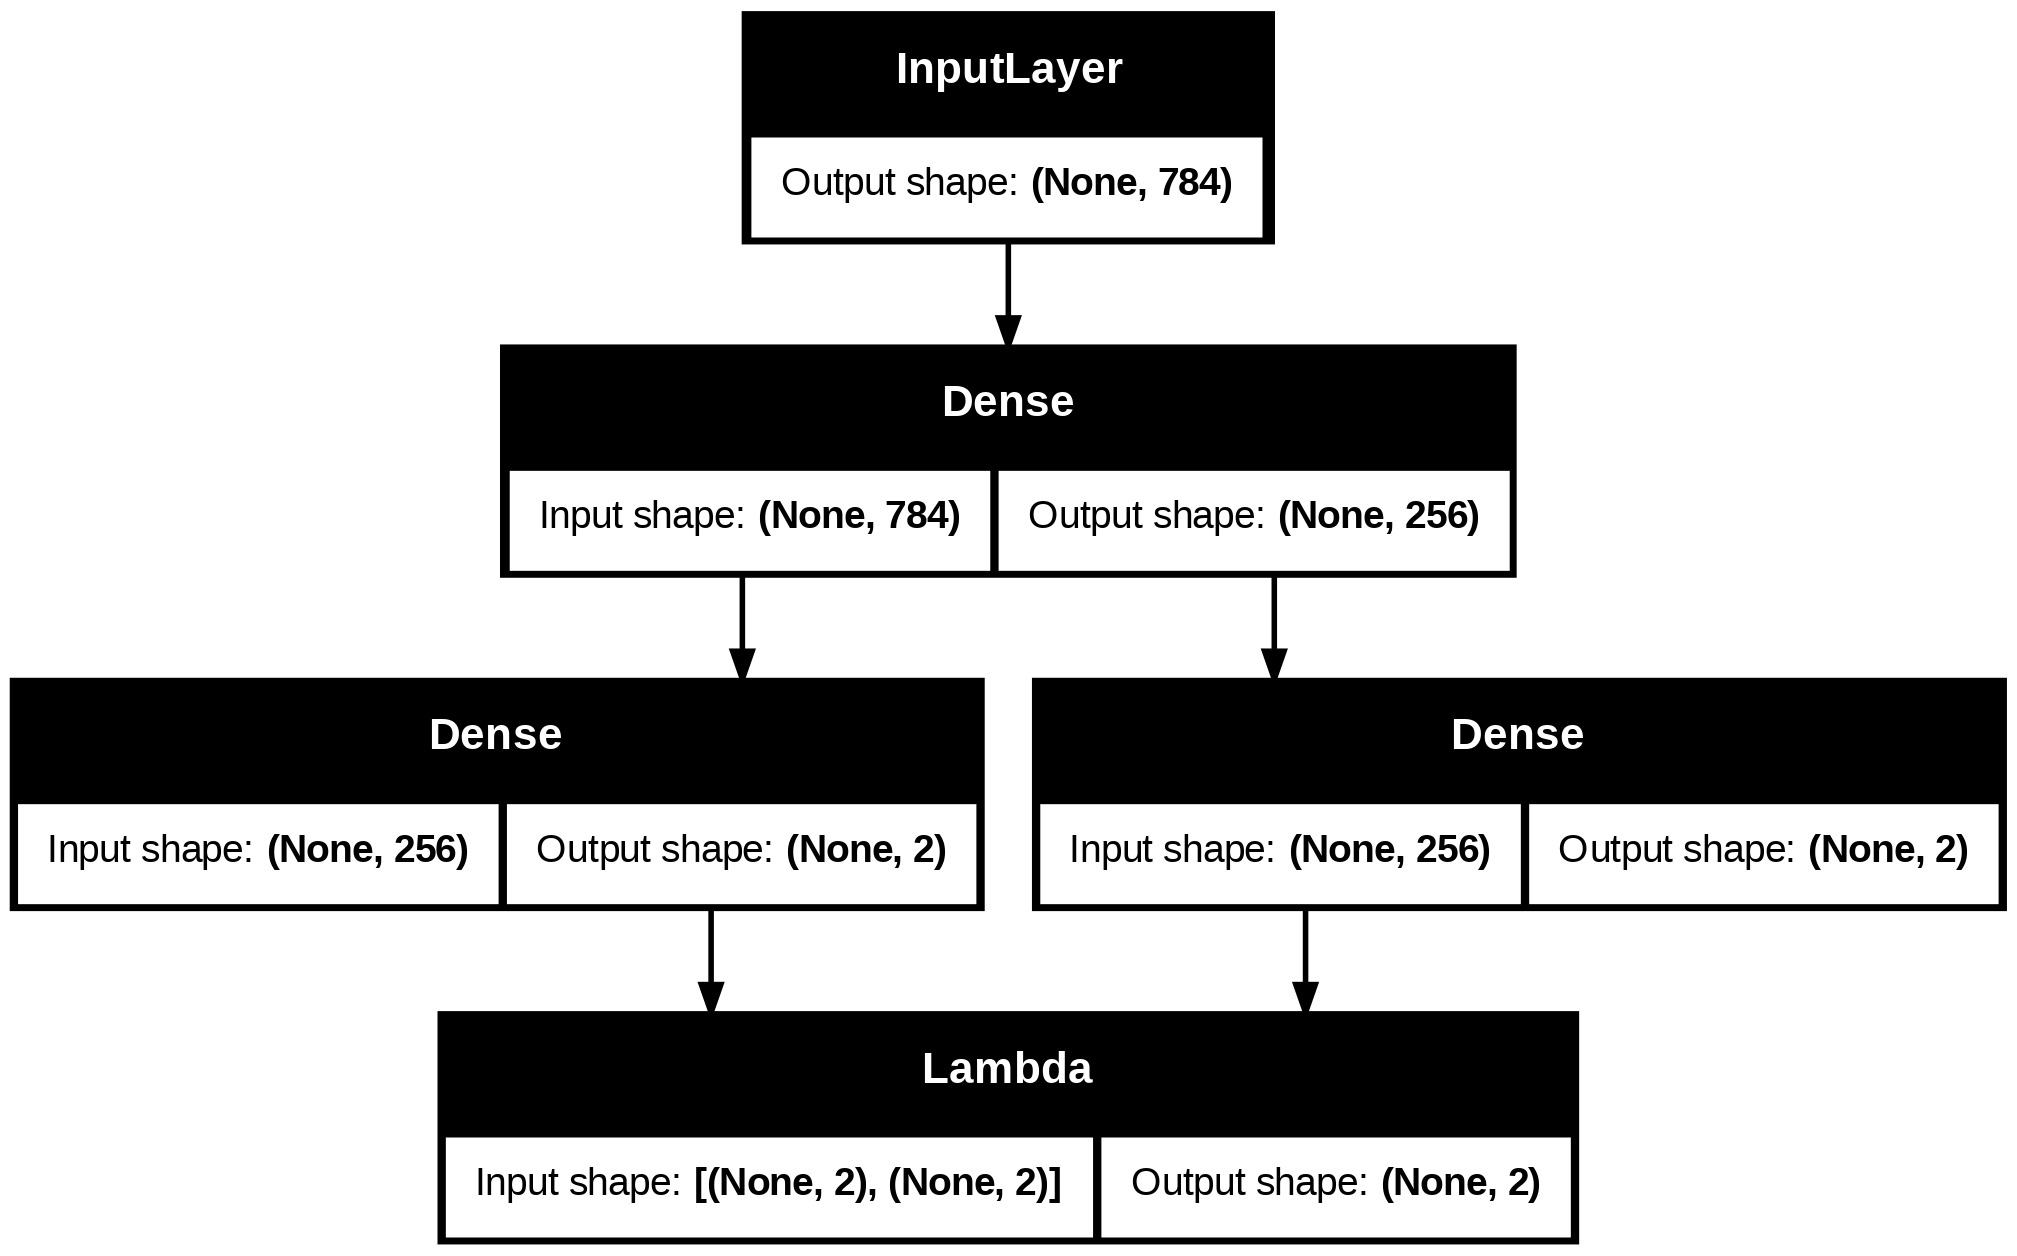

In [ ]:
tf.keras.utils.plot_model(encoder, show_shapes=True)

Decoder

In [ ]:
# 디코더 입력은 latent 변수로부터
input = tf.keras.Input(shape=(latent_size,), name='input')
hidden = tf.keras.layers.Dense(
    n_hidden, activation='relu', name='hidden')(input)
# 출력은 인코더 입력과 같도록 학습하기 때문에 input_size가 사용
output = tf.keras.layers.Dense(
    input_size, activation='sigmoid',name='output')(hidden)
decoder = tf.keras.Model( input, output, name='decoder' )

In [ ]:
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden (Dense)                  │ (None, 256)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,256 (790.06 KB)

 Trainable params: 202,256 (790.06 KB)

 Non-trainable params: 0 (0.00 B)

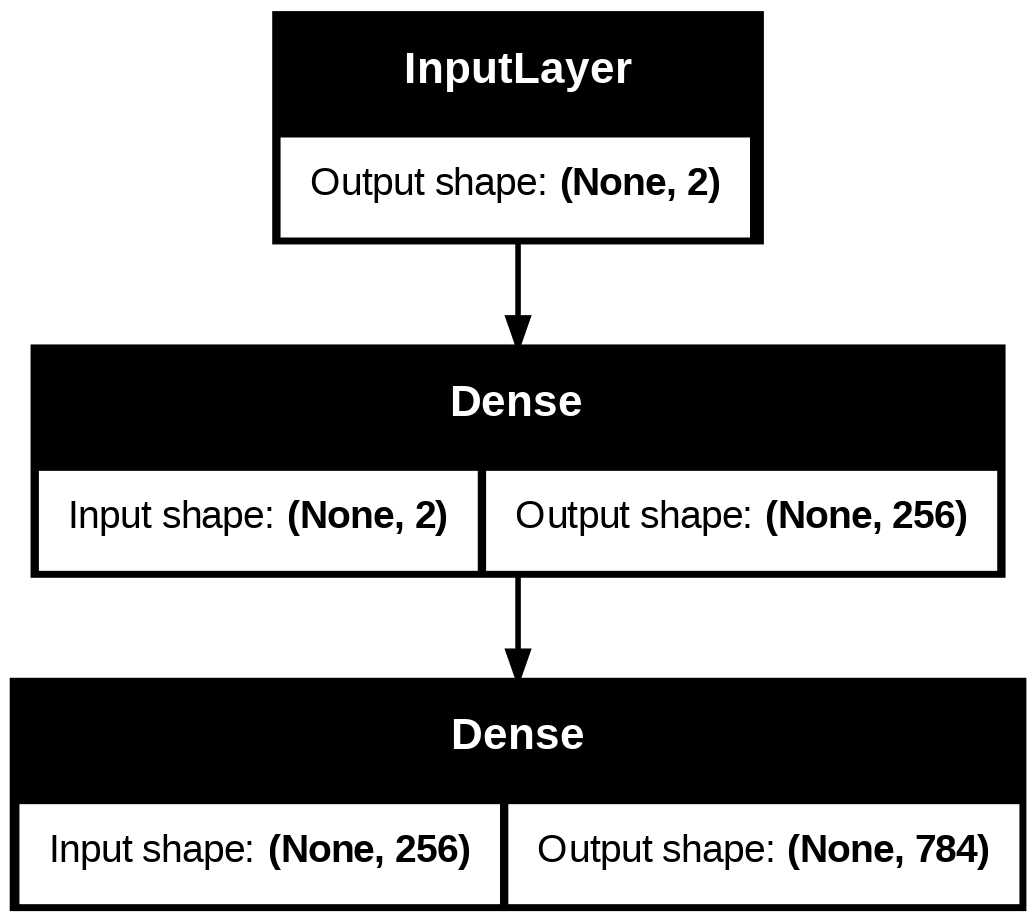

In [ ]:
tf.keras.utils.plot_model(decoder, show_shapes=True)

VAE

In [ ]:
input = tf.keras.Input(shape=(input_size,), name='input')
z = encoder(input)[2]  # [0]: z_mean, [1]: z_var, [2]: z
output = decoder(z)
model = tf.keras.Model(input, output, name='vae')

In [ ]:
model.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ [(None, 2), (None, 2), │       201,988 │
│                                 │ (None, 2)]             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 784)            │       202,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,244 (1.54 MB)

 Trainable params: 404,244 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

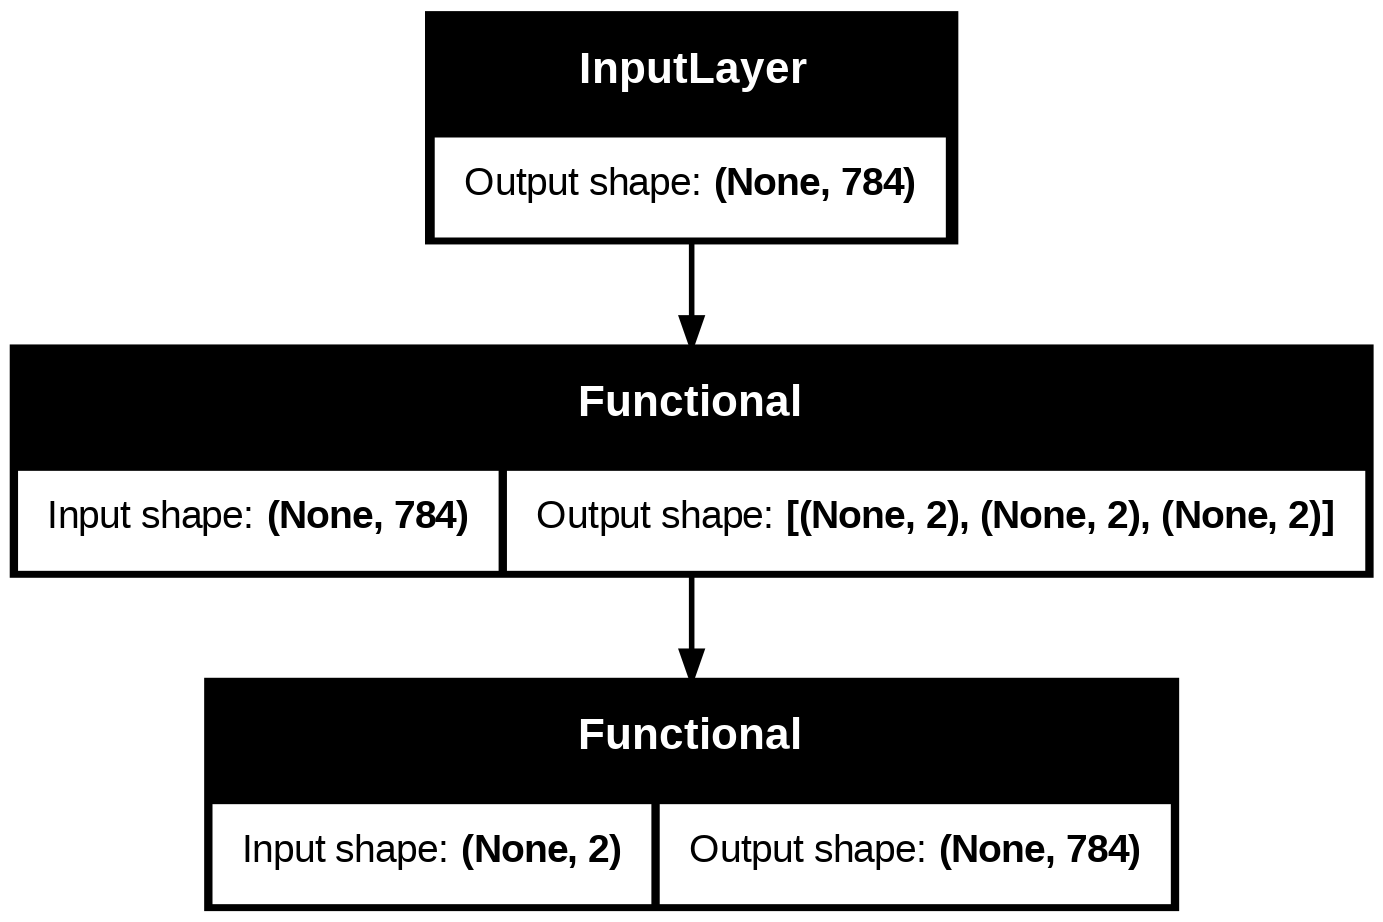

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

훈련

In [ ]:
# 훈련 파라메터   
r_loss_factor = 1000

In [ ]:
# 손실함수 정의
def vae_loss(x, recon_x):
  # 재구성을 위한 복원 손실
  m, v, z = encoder(x)
  recon_x = decoder(z)
  r_loss = tf.keras.losses.mse(x,recon_x)
  # 원하는 분포로 맞추기 위한 KL Divergence 손실
  # m = 0, v = log(var) = 0이 되면 최소
  kl_loss = 0.5*tf.reduce_sum(tf.square(m) + tf.exp(v) - v - 1, axis=1)
  return tf.reduce_mean(r_loss*r_loss_factor + kl_loss)

In [ ]:
model.compile(optimizer='adam',loss=vae_loss)

In [ ]:
model.fit( xtrain, xtrain, epochs=20 )

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 69.9293
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 53.3282
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 51.9491
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 51.0656
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 50.3107
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 49.8160
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 49.3403
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 48.8703
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 48.7130
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 48.4247
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 48.2970
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 47.8841
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 47.8267
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 47.6264
Epoch 15/20
187

복원 테스트

In [ ]:
r_xtest = model.predict(xtest)
print("mse: ",np.array(tf.keras.losses.mse(xtest,r_xtest)).mean())

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
mse:  0.0421745


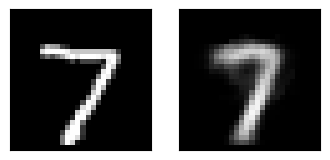

In [ ]:
plt.figure(figsize=(4, 8))
ax = plt.subplot(1, 2, 1)
plt.imshow(xtest[0].reshape(28,28), vmin=0, vmax=1, cmap="gray")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(1, 2, 2)
plt.imshow(r_xtest[0].reshape(28,28), vmin=0, vmax=1, cmap="gray")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

생성 테스트

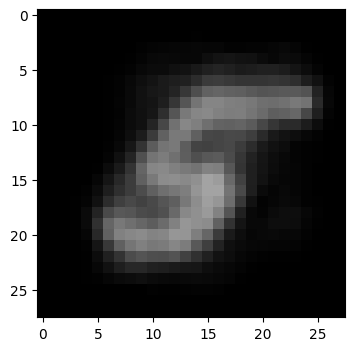

In [ ]:
# N(0,1)을 따르는 2차원 잠재변수를 입력으로
new = decoder(np.array([[0,0]]))
plt.figure(figsize=(4, 4))
plt.imshow(np.array(new[0]).reshape(28,28), vmin=0, vmax=1, cmap="gray")

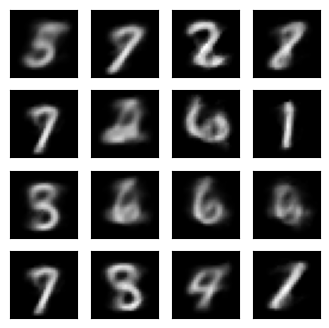

In [ ]:
plt.figure(figsize=(4, 4))
for i in range(16):
  new = decoder( np.random.randn(2).reshape((1,2)) )
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(np.array(new[0]).reshape(28,28), vmin=0, vmax=1, cmap="gray")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

# 연습문제

1. 위의 코드에서 네트워크/훈련 파라메터를 적절히 조절하여 더 나은 결과를 얻을 수 있는지 확인하시오. Seed는 0으로 고정하며, 언급된 요소를 제외한 나머지 학습 파라미터는 기존 코드와 동일하게 학습하시오. <br>
(1) 기존 모델의 n_hidden을 128로 변경 하였을 때 VAE 모델의 학습가능한 파라메터 수는 몇 개인가?<br>
(2) (1)으로 변경된 모델을 학습 하였을 때, 평가 데이터의 MAE는 얼마인가?<br>
(3) 생성이 얼마나 잘 되는지를 평가할 수 있는 방안을 고안하여 간략히 서술하시오.<br>

In [ ]:
import tensorflow as tf
import numpy as np

tf.random.set_seed(0)
np.random.seed(0)